In [1]:
import argparse
import os, sys
import time
import datetime
import csv

import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

# You cannot change this line.
from tools.dataloader import CIFAR10

from tools.dataloader1 import CIFAR10_1

In [2]:
""" 
Assignment 2(a)
Build the LeNet-5 model by following table 1 or figure 1.

You can also insert batch normalization and leave the LeNet-5 
with batch normalization here for assignment 3(c).
"""
# Create the neural network module: VGG-16
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.conv1 = nn.Conv2d(3,64,3, padding=1)
        self.conv1bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.conv2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv3bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.conv4bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        self.conv5bn = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,256,3,padding=1)
        self.conv6bn = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256,256,3,padding=1)
        self.conv7bn = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256,512,3,padding=1)
        self.conv8bn = nn.BatchNorm2d(512)
        self.conv9 = nn.Conv2d(512,512,3,padding=1)
        self.conv9bn = nn.BatchNorm2d(512)
        self.conv10 = nn.Conv2d(512,512,3,padding=1)
        self.conv10bn = nn.BatchNorm2d(512)
        self.conv11 = nn.Conv2d(512,512,3,padding=1)
        self.conv11bn = nn.BatchNorm2d(512)
        self.conv12 = nn.Conv2d(512,512,3,padding=1)
        self.conv12bn = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512,512,3,padding=1)
        self.conv13bn = nn.BatchNorm2d(512)
#         self.fc1 = nn.Linear(512, 4096)    # no maxpool padding
        self.fc1 = nn.Linear(512*2*2, 4096)    # with maxpool padding
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        out = self.conv1(x)
#         out = self.conv1bn(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.conv2bn(out)
        out = F.relu(out)
        out = F.max_pool2d(out,2)
        out = self.conv3(out)
#         out = self.conv3bn(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = self.conv4bn(out)
        out = F.relu(out)
        out = F.max_pool2d(out,2)
        out = self.conv5(out)
#         out = self.conv5bn(out)
        out = F.relu(out)
        out = self.conv6(out)
#         out = self.conv6bn(out)
        out = F.relu(out)
        out = self.conv7(out)
        out = self.conv7bn(out)
        out = F.relu(out)
        out = F.max_pool2d(out,2)
        out = self.conv8(out)
#         out = self.conv8bn(out)
        out = F.relu(out)
        out = self.conv9(out)
#         out = self.conv9bn(out)
        out = F.relu(out)
        out = self.conv10(out)
        out = self.conv10bn(out)
        out = F.relu(out)
        out = F.max_pool2d(out,2)
        out = self.conv11(out)
#         out = self.conv11bn(out)
        out = F.relu(out)
        out = self.conv12(out)
#         out = self.conv12bn(out)
        out = F.relu(out)
        out = self.conv13(out)
        out = self.conv13bn(out)
        out = F.relu(out)
        out = F.max_pool2d(out,2,padding=1)    # maxpool padding
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.drop2(out)
        out = F.relu(out)
        out = self.fc3(out)
        
        return out

In [3]:
"""
Hyperparameter optimization in assignment 4(a), 4(b) can be 
conducted here.
Be sure to leave only your best hyperparameter combination
here and comment the original hyperparameter settings.
"""

# Setting some hyperparameters
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
#INITIAL_LR = 0.01
INITIAL_LR = 0.009
MOMENTUM = 0.9
# REG = 1e-4
REG = 6e-4
#EPOCHS = 30
EPOCHS = 50
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"


**Your answer:**

In [4]:
"""
Assignment 2(b)
Write functions to load dataset and preprocess the incoming data. 
We recommend that the preprocess scheme \textbf{must} include 
normalize, standardization, batch shuffling to make sure the training 
process goes smoothly. 
The preprocess scheme may also contain some data augmentation methods 
(e.g., random crop, random flip, etc.). 

Reference value for mean/std:

mean(RGB-format): (0.4914, 0.4822, 0.4465)
std(RGB-format): (0.2023, 0.1994, 0.2010)


NOTE: Considering this process has strong corrlelation with assignment 3(b), 
please leave the data preprocessing method which can achieve the highest 
validation accuracy here. You can include your original data augmentation
method as comments and denotes the accuracy difference between thest two 
methods.
"""
# Specify preprocessing function.
# Reference mean/std value for 
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val= transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
])

transform_test= transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
])



**Your answer:**

In [5]:
# Call the dataset Loader
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=1)

# test set
testset = CIFAR10_1(root=DATAROOT, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=1)

Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval.tar.gz
Extracting ./data/cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10-batches-images-test.tar.gz
Extracting ./data/cifar10-batches-images-test.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = VGG16()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [7]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = True
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model_train.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Training from scratch ...
Starting from learning rate 0.009000:


In [8]:
"""
Assignment 2(c)
In the targeted classification task, we use cross entropy loss with L2 
regularization as the object.
You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.
We recommend you to use the SGD-momentum with an initial learning rate 0.01 
and momentum 0.9 as a start.
"""
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

2019-10-03 01:35:32.837683
Epoch 0:
176
Initial loss: 2.3052
Training loss: 1.6912, Training accuracy: 0.4353
2019-10-03 01:35:50.342440
Validation...
Validation loss: 1.2701, Validation accuracy: 0.5516
Saving ...
2019-10-03 01:35:52.189983
Epoch 1:
176
Training loss: 1.0005, Training accuracy: 0.6540
2019-10-03 01:36:04.654475
Validation...
Validation loss: 1.0196, Validation accuracy: 0.6440
Saving ...
2019-10-03 01:36:06.637886
Epoch 2:
176
Training loss: 0.7532, Training accuracy: 0.7402
2019-10-03 01:36:19.171582
Validation...
Validation loss: 0.7737, Validation accuracy: 0.7294
Saving ...
2019-10-03 01:36:21.155081
Epoch 3:
176
Training loss: 0.6245, Training accuracy: 0.7835
2019-10-03 01:36:34.035050
Validation...
Validation loss: 1.1660, Validation accuracy: 0.6298
2019-10-03 01:36:35.376109
Epoch 4:
176
Training loss: 0.5480, Training accuracy: 0.8149
2019-10-03 01:36:47.337847
Validation...
Validation loss: 0.8940, Validation accuracy: 0.7024
2019-10-03 01:36:48.475277
Epoc

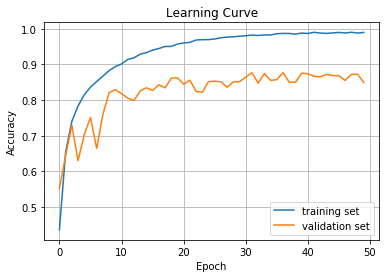

In [9]:
"""
Assignment 3(a)
Start the training process over the whole CIFAR-10 training dataset. 
For sanity check, you are required to report the initial loss value at 
the beginning of the training process and briefly justify this value. 
Run the training process for \textbf{a maximum of 30} epochs and you 
should be able to reach around \textbf{65\%} accuracy on the validation 
dataset.
"""
# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0

# create array for train_accu and valid_accu
train_accu = np.zeros(EPOCHS)
valid_accu = np.zeros(EPOCHS)

current_learning_rate = INITIAL_LR

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device 
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        # print out initial loss
        if (i==start_epoch and batch_idx==0):
            print("Initial loss: %.4f" %loss)
        
        
        # Now backward loss
        loss.backward()
        
        
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        # Calculate accuracy
        total_examples += targets.size(0)
        correct_examples += (predicted.eq(targets)).sum().item()

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    train_accu[i] = avg_acc
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            # Calculate accuracy
            total_examples += targets.size(0)
            correct_examples += (predicted.eq(targets)).sum().item()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    valid_accu[i] = avg_acc
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    

        
    """
    Assignment 4(b)
    Learning rate is an important hyperparameter to tune. Specify a 
    learning rate decay policy and apply it in your training process. 
    Briefly describe its impact on the learning curveduring your 
    training process.    
    Reference learning rate schedule: 
    decay 0.98 for every 2 epochs. You may tune this parameter but 
    minimal gain will be achieved.
    Assignment 4(c)
    As we can see from above, hyperparameter optimization is critical 
    to obtain a good performance of DNN models. Try to fine-tune the 
    model to over 70% accuracy. You may also increase the number of 
    epochs to up to 100 during the process. Briefly describe what you 
    have tried to improve the performance of the LeNet-5 model.
    """
    DECAY_EPOCHS = 5
    DECAY = 0.2
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate *= DECAY 
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            lr = current_learning_rate
            
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model_train.h5'))

print("Optimization finished.")

# plot accuracy
epoch = np.arange(EPOCHS)
fig, ax = plt.subplots()
ax.plot(epoch, train_accu, label='training set')
ax.plot(epoch, valid_accu, label='validation set')

ax.set(xlabel='Epoch', ylabel='Accuracy',
title='Learning Curve')
ax.grid()
legend = ax.legend()

plt.show()

In [10]:
# predict test outputs

# initialize array to store predicted labels
size = testset.data.shape[0]  # total images, 10000
predicted_labels = np.zeros(size)

net.eval()
# Disable gradient during testing
with torch.no_grad():
    for batch_idx, (inputs) in enumerate(testloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output from the DNN.
        outputs = net(inputs)
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        for i in range(TEST_BATCH_SIZE):
            predicted_labels[i+TEST_BATCH_SIZE*batch_idx] = predicted[i].item()
            
# write to csv
index = np.arange(size)
name = ('Id','Category')
with open('prediction.csv', 'w', ) as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(name)
    for i in range(size):
        wr.writerow((index[i],int(predicted_labels[i])))
